In [2]:
!pip3 install trajpy

Importando pacotes

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import trajpy.trajpy as tj
import trajpy.traj_generator as gen
import pandas as pd

Importando dados trajetória Lennard-Jones

In [4]:
#autocorrelacao = np.loadtxt('vacf2_2.dat')
#corr_md_novo = autocorrelacao[:,2] #valor da autocorr.
#corr_t_novo = autocorrelacao[:,0] #t da coordenada
#msd = np.loadtxt('msd _2.dat')
#msd_t = msd[0:170,0]
#msd_dx1 = msd[0:170,2]
dados = np.loadtxt('snapshot_2.xyz')
t_dados = dados[:,0]
x1_dados = dados[:,1]
x1_dados = x1_dados.reshape(-1,1)
t_dados = t_dados.reshape(-1,1)
trajetoria = np.concatenate((t_dados,x1_dados),axis=1)

In [5]:
x2_dados = dados[:,5]
x2_dados = x2_dados.reshape(-1,1)

Função nova para autocorrelação

In [ ]:
def autocorrelacao_nova(coor,taus,dt):

  media_temporal = np.zeros(len(taus))
  velocidade = np.diff(coor, axis=0)/dt
  N = len(velocidade)
  for tau in taus:
    media_temporal[tau] = (np.sum(np.einsum('ij,ij->i',
                np.take(a=velocidade,indices=np.arange(0,N-tau)+tau,axis=0),
                np.take(a=velocidade,indices=np.arange(0,N-tau),axis=0)))+ 
                media_temporal[tau-1])*dt / (N-tau)

  return media_temporal


Função do Trajpy para autocorrelação

In [ ]:
def autocorrelacao_antiga(coor,tau):
    dt = t_dados[1]-t_dados[0]
    velocidade = np.diff(coor, axis=0)/dt
    time_averaged_corr_velocity = 0.
    N = len(velocidade)
    correlacao = np.zeros(len(tau))
    for value in tau:
        for n in range(0, N-value):
            time_averaged_corr_velocity += np.dot(velocidade[n+value, :], velocidade[n, :])
        time_averaged_corr_velocity = time_averaged_corr_velocity*dt / (N-value)
        correlacao[value] = time_averaged_corr_velocity
    return correlacao

Plot comparativo da autocorrelação pelo Trajpy, Espresso e função nova 

In [ ]:
plt.figure(dpi=150)
plt.plot(corr_t_novo,corr_md_novo,label='Espresso')
plt.plot(np.arange(0,100),autocorrelacao_nova(x1_dados,np.arange(0,100),dt=t_dados[1]-t_dados[0]),label='função nova')
plt.xlim(-1,10)
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=150)
plt.plot(np.arange(0,20),autocorrelacao_antiga(x1_dados,np.arange(0,20)),label='Função Antiga')
plt.plot(np.arange(0,20),autocorrelacao_nova(x1_dados,np.arange(0,20),dt=t_dados[1]-t_dados[0]),label='Função Nova')
plt.legend()
plt.show()

Benchmarcks

In [ ]:
t = [10,20,40,50,100]
run_s_funcao_nova = []
run_min_funcao_nova = []
for i in t:
  import time
  inicio = time.time()
  correlacao_nova = autocorrelacao_nova(x1_dados,np.arange(0,i),dt=t_dados[1]-t_dados[0])
  fim = time.time()
  run = fim - inicio
  run_s_funcao_nova.append(run)

In [ ]:
run_s_funcao_antiga = []
run_min_funcao_antiga = []
for i in t:
  import time
  inicio = time.time()
  correlacao_antiga = autocorrelacao_antiga(x1_dados,np.arange(0,i))
  fim = time.time()
  run = fim - inicio
  run_s_funcao_antiga.append(run)

In [ ]:
run_min_funcao_nova = [i/60 for i in run_s_funcao_nova]
print('Benchmarks on Google Colab:')
for i in range(0,len(t)):
  print('Tau =',t[i],':  Função antiga:',run_s_funcao_antiga[i],'segundos;','Função nova:',run_s_funcao_nova[i],'segundos')

In [ ]:
t = [10,20,40,50,100]
#run_s_funcao_antiga = [44.6,91.1,184.8,231.5,466.4] #valores salvos segundos
run_min_funcao_antiga = [i/60 for i in run_s_funcao_antiga]
fig = plt.figure(dpi=100)
plt.bar(t,run_min_funcao_antiga,width=4.0,label='Função antiga')
plt.bar(t,run_min_funcao_nova,width=4.0,label='Função nova')
plt.xticks(t)
#plt.yticks(run_min)
plt.xlabel(r'$\tau$ Length')
plt.ylabel("Run Time (min)")
plt.title("Run Time x Tau Length for Trajpy Autocorrelation Function in Google Colab")

plt.ylim(0,0.1)
plt.legend()
plt.grid()
plt.show()

Função para gerar arquivo de trajetória pelo traj_generator

In [ ]:
def gen_traj(file_name,length):
  # file = file name as string
  # length = number of trajectories for each kind
  # !!!Feature calculation changes must be made by hand!!!
  arquivo = open(file_name,'a')
  colunas = ['msd_time_average',',','fractal_dimension',',','straightness',',','gaussianity',
             ',','efficiency',',','diffusion']
  arquivo.writelines(colunas)
  arquivo.writelines('\n')
  for i in range(0,length):
    tempo,x = gen.normal_diffusion(n_steps=100,n_samples=3,dx=1.0,
                                  y0=0.0,D=i+1,dt=0.1)
    tempo = tempo.reshape(-1,1)
    data = np.concatenate((tempo,x),axis=1)
    r = tj.Trajectory()
    lista = [str(r.msd_time_averaged(x,1)[0]),',',
            str(r.fractal_dimension_(x)[0]),',',
            str(r.straightness_(x)),',',
            str(r.gaussianity_(x)),',',
            str(r.efficiency_(x)),',',
            str('normal')]                                                                                       
    
    arquivo.writelines(lista)
    arquivo.writelines('\n')

  for i in range(0,length):
    tempo,x = gen.anomalous_diffusion(n_steps=100,n_samples=3,
                                      time_step=0.1,alpha=np.random.random())
    tempo = tempo.reshape(-1,1)
    data = np.concatenate((tempo,x),axis=1)
    r = tj.Trajectory()
    lista = [str(r.msd_time_averaged(x,1)[0]),',',
            str(r.fractal_dimension_(x)[0]),',',
            str(r.straightness_(x)),',',
            str(r.gaussianity_(x)),',',
            str(r.efficiency_(x)),',',
            str('anomalous')]  
    
    arquivo.writelines(lista)
    arquivo.writelines('\n')

  for i in range(0,length):
    tempo,x = gen.confined_diffusion(radius=i+1,n_steps=100,n_samples=3,
                                    dx=1.0,y0=0.0,D=1.0,dt=0.1)
    tempo = tempo.reshape(-1,1)
    data = np.concatenate((tempo,x),axis=1)
    r = tj.Trajectory()
    lista = [str(r.msd_time_averaged(x,1)[0]),',',
            str(r.fractal_dimension_(x)[0]),',',
            str(r.straightness_(x)),',',
            str(r.gaussianity_(x)),',',
            str(r.efficiency_(x)),',',
            str('confined')]
    
    arquivo.writelines(lista)
    arquivo.writelines('\n')

  for i in range(0,length):
    tempo,x = gen.superdiffusion(velocity=i+1,n_steps=100,n_samples=3,y0=0.0,dt=0.1)
    tempo = tempo.reshape(-1,1)
    data = np.concatenate((tempo,x),axis=1)
    r = tj.Trajectory()
    lista = [str(r.msd_time_averaged(x,1)[0]),',',
            str(r.fractal_dimension_(x)[0]),',',
            str(r.straightness_(x)),',',
            str(r.gaussianity_(x)),',',
            str(r.efficiency_(x)),',',
            str('superdiffusion')]

    arquivo.writelines(lista)
    arquivo.writelines('\n')

Chamando a função com argumentos 

In [ ]:
gen_traj(file_name='trajectories.csv',lenght=100)

Lendo o arquivo de trajetórias

In [ ]:
import pandas as pd
dados = pd.read_csv('trajectories.csv')
dados.columns = ['msd_time_average', 'fractal_dimension', 'straightness', 'gaussianity',
       'efficiency', 'diffusion']

Plotando gráficos comparativos pelo plotly

In [ ]:
import plotly.express as px
df = dados
fig = px.scatter_matrix(df,
    dimensions=['msd_time_average', 'fractal_dimension', 'straightness', 'gaussianity','efficiency'],
    color=dados['diffusion'],width=1000, height=800)
fig.update_traces(diagonal_visible=False)
fig.show()

Gerando gráficos comparativos pelo Seaborn

In [ ]:
import seaborn as sns
sns.pairplot(dados, hue="diffusion",diag_kind='auto')
plt.show()

Importando Decision Tree Classifier (validação cruzada,fit e matriz de confusão)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score #importa o cálculo da acurácia do modelo
from  sklearn.model_selection import StratifiedKFold #importa o método de subdivisão  
y = dados['diffusion']
x = dados.drop('diffusion',axis=1)
skfold = StratifiedKFold(n_splits=5) #separamos em 5 subdivisões

#criando o modelo
modelo = DecisionTreeClassifier()
resultado = cross_val_score(modelo,x,y,cv=skfold)
print(resultado.mean())

0.975


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
xtreino,xteste,ytreino,yteste = train_test_split(x,y,test_size=0.7)
modelo.fit(xtreino,ytreino)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('True Label', fontsize=15)
ax.set_xlabel('Predicted Label', fontsize=15)
ax.tick_params(axis='y',labelsize=15) 
ax.tick_params(axis='x',labelsize=15)
ax.set_title('Classification Confusion Matrix',fontdict={'fontsize': 20})
plot_confusion_matrix(modelo, xteste, yteste,cmap='Blues',ax=ax,xticks_rotation='50') 
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import keras
from keras.utils import np_utils
y_keras = dados['diffusion']
y_keras.replace('normal',0,inplace=True)
y_keras.replace('anomalous',1,inplace=True)
y_keras.replace('confined',2,inplace=True)
y_keras.replace('superdiffusion',3,inplace=True)
x_keras = dados.drop('diffusion',axis=1)
y_convertido = np_utils.to_categorical(y_keras)

Importando pacotes Keras para fit

In [ ]:
from sklearn.model_selection import train_test_split
xtreino_keras,xteste_keras,ytreino_keras,yteste_keras = train_test_split(x_keras,y_convertido,test_size=0.7)


In [ ]:
from keras.models import Sequential #modelo par criar uma rede neural sequencial, onde cada camada se conceta com a
#próxima
from keras.layers import Dense, Activation
from keras.optimizers import SGD #importa o método de otimização do Gradiente Descendente Estocástico
modelo_keras = Sequential()
modelo_keras.add(Dense(10,input_dim=5,kernel_initializer='normal',activation='sigmoid'))
modelo_keras.add(Dense(4,kernel_initializer='normal',activation='softmax'))
otimizador = keras.optimizers.SGD()
modelo_keras.compile(loss='categorical_crossentropy',optimizer=otimizador,metrics=['acc'])
modelo_keras.fit(xtreino_keras,ytreino_keras,epochs=1000,batch_size=30,validation_data=(xteste_keras,yteste_keras),verbose=0)

In [ ]:
y_pred = modelo_keras.predict_classes(xteste_keras,batch_size=32,verbose=0)
classes = np.zeros(4) 
for i in range(len(y_pred)):
  if y_pred[i] == 0:
    classes[0] += 1
  elif y_pred[i] == 1:
    classes[1] += 1
  elif y_pred[i] == 2:
    classes[2] += 1
  else:
    classes[3] +=1
print(classes)
print(sum(classes))


Plotly 3D Plots

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0.0, 3.0, 50)
y = np.linspace(0.0, 3.0, 50)
xGrid, yGrid = np.meshgrid(y, x)

def teste(xGrid,yGrid,n): #INTERACTIVE GRAPH
    z = 0.0
    for i in range(1,n,2):
        z = z + np.sin(i*yGrid)/(i*np.e**(i*xGrid))
        #print(np.sin(i*yGrid))
    return z
Z = teste(xGrid,yGrid,2)

fig = fig = go.Figure(data=[go.Surface(z=Z, x=xGrid, y=yGrid)])
fig.show()

Regular 3D Plot

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(-1.0,1.0,20)
y = np.linspace(0.0,1.0,20)
X,Y = np.meshgrid(x,y)
def funcao(x,y):    #REGULAR 3D GRAPH
    for i in range(1,20,2):
        return 4/i*(np.cosh(i*np.pi*x))/(np.cosh(i*np.pi))*np.sin(i*np.pi*y)
Z = funcao(X,Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z,cmap='magma')
ax.set_xlabel('s/R')
ax.set_ylabel('phi')
ax.set_zlabel('V/V0')

Gráfico autocorrelação com ZOOM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
if __name__=='__main__':
    fig = plt.figure(dpi=150)
    ax = plt.subplot(111) #whole path
    plt.title('Velocity Autocorrelation Function')
    plt.ylabel(r'$C(\tau)$')
    plt.xlabel(r'$\tau$')
    plt.plot(correlacao[:,0],correlacao[:,1],label='ESPResSo')
    plt.plot(np.arange(0,100),autocorrelacao_nova(x1_dados,np.arange(0,100),dt=t_dados[1]-t_dados[0])
         ,label='TrajPy')
    ax.set_xlim(-1,100) #altera limites do eixo x do gráfico principal
    ax.set_ylim(-1,6) #altera limites do eixo y do gráfico principal
    #ax.grid()
    ax.legend() #legendas do gráfico principal

    axins = zoomed_inset_axes(ax,3,loc='center') #número altera o tamanho do zoom e loc altera a localização
    #da janela de zoom
    axins.plot(correlacao[:,0],correlacao[:,1])
    axins.plot(np.arange(0,100),autocorrelacao_nova(x1_dados,np.arange(0,100),dt=t_dados[1]-t_dados[0]))

    x1,x2,y1,y2 = 37,59, -0.5,0.5 #altera os limites para a região que daremos zoom
    axins.set_xlim(x1,x2)
    axins.set_ylim(y1,y2)
    #axins.grid()

    #mark_inset(ax,axins,loc1=3,loc2=4) #altera de quais vértices saem as linhas diagonais do zoom
    plt.show()

Fast Fourier Transform

In [ ]:
def fftPlot(sig, dt=None, plot=True):
    # Here it's assumed analytic signal (real signal...) - so only half of the axis is required
    import warnings
    if dt is None:
        dt = 1
        t = np.arange(0, sig.shape[-1])
        xLabel = 'samples'
    else:
        t = np.arange(0, sig.shape[-1]) * dt
        xLabel = 'freq [Hz]'

    if sig.shape[0] % 2 != 0:
        warnings.warn("signal preferred to be even in size, autoFixing it...")
        t = t[0:-1]
        sig = sig[0:-1]
    
    
    xLabel = 'freq [Hz]'
    sigFFT = np.fft.fft(sig) / t.shape[0]  # Divided by size t for coherent magnitude

    freq = np.fft.fftfreq(t.shape[0], d=dt)

    # Plot analytic signal - right half of frequence axis needed only...
    firstNegInd = np.argmax(freq < 0)
    freqAxisPos = freq[0:firstNegInd]
    sigFFTPos = 2 * sigFFT[0:firstNegInd]  # *2 because of magnitude of analytic signal
    
    # filtro para eixo x com frequência
    max_index = np.max(np.where(np.round(np.abs(sigFFTPos),1)>0))
    
    #calculos de propriedades das frequências não nulas (positivas, por definição)
    


    if plot:
        plt.figure(dpi=150)
        plt.title('Analytic FFT plot')
        plt.subplot(211)
        plt.xlabel('Time [unit]')
        plt.ylabel('Amplitude')
        plt.plot(t,sig)
        #plt.ylim(min(sinal)-10,max(sinal)+10)

        plt.subplot(212)
        plt.xlabel(xLabel)
        plt.ylabel('Amplitude')
        plt.xlim(0,freqAxisPos[max_index]+5)
        plt.plot(freqAxisPos, np.abs(sigFFTPos))
        plt.grid()
        plt.tight_layout()
        plt.show()

    #return np.round(np.abs(sigFFTPos),1)sigFFTPos, freqAxisPos
    return freqAxisPos[np.where(np.round(np.abs(sigFFTPos),1)>0)]


In [ ]:
vetor = np.array([0,0,0,2,5,0,5,2,0,])
outro = np.array([1,2,3,4,5,7,5,5,9])
outro[np.where(np.round(np.abs(vetor),1)>0)]


array([4, 5, 5, 5])

In [ ]:
a = np.array([1,2,3]) #valores
b = np.array([1,2,3]) #repetições
sum(a * b) 

14

In [ ]:
dt = 1/1000
time = np.arange(0,10,dt)
sinal =  5*np.sin(2*np.pi*8*time) + 10*np.sin(2*np.pi*3*time) + 1*np.sin(2*np.pi*3*time) + 3*np.sin(2*np.pi*10*time)+7*np.sin(2*np.pi*10*time)
fftPlot(sig=sinal,dt=dt,plot=False)

array([ 3.,  8., 10.])

In [ ]:

r = tj.Trajectory()
msd = r.msd_ensemble_averaged(x1_dados)
fftPlot(msd,dt=t_dados[1]-t_dados[0],plot=False)

Novas features para velocidade:

In [10]:
def velocity_(position,t):
        """
            computes the velocity associated with the trajectory stored in (self._r, self._t)
        """
        
        velocity = np.diff(position, axis=0)/(t[1]-t[0])

        return velocity

In [ ]:
def velocity_description_(velocity): #descrição completa em uma função?
    """
        computes the skewness (lack of simmetry) of a frequency distribuition.Positive result implies 
        distribuition's tail to the right, negative implies tail to the left and zero implies simmetric
        distribuition
        
        .. math::
                g_1 = \\frac{m_3}{m_2^{\\frac{3}{2}}}
        
        :param data: data to be analyzed
        :return skewness: skewness
    """
    
    mean = np.mean(velocity,axis=0) #média das velocidades 
    #!!!!!!(PARA SITUAÇÕES ONDE VALORES DE VELOCIDADE NÃO SE REPETEM, caso repita: média ponderada - descobrir como)!!!!!!
    median = np.median(velocity,axis=0) #mediana das velocidades
    standard_deviation = np.std(velocity,axis=0) #desvio padrão das velocidades
    variance = np.var(velocity,axis=0) #variância das velocidades
    #range = max(v1)-min(v1),max(v2)-min(v2),...??????? 
    ############ SKEWNESS ####################################
    m3 = np.zeros(velocity.shape[1])
    m2 = np.zeros(velocity.shape[1])
    skewness = np.zeros(velocity.shape[1])
    for i in range(velocity.shape[1]):
      for l in range(len(velocity)):
        m3[i] += (velocity[l,i] - mean[i])**3
        m2[i] += (velocity[l,i] - mean[i])**2
    m2 = m2/len(velocity)
    m3 = m3/len(velocity)
    skewness = m3/(m2**1.5)
    ########### KURTOSIS ####################################
    kurtosis = np.zeros(velocity.shape[1])
    m4 = np.zeros(velocity.shape[1])
    for i in range(velocity.shape[1]):
        for l in range(len(velocity)):
           m4[i] += (velocity[l,i] - mean[i])**4
    m4 = m4/len(velocity)
    kurtosis = m4/(standard_deviation**4) + (-3)
    ######## MODE ##########################################
    # ??????????????????????????????????????????????
    return mean, median, standard_deviation,variance,skewness,kurtosis

In [ ]:
descricao = velocity_description_(velocidade)

In [80]:
def autocorrelacao_nova(coor,taus,dt):

  media_temporal = np.zeros(len(taus))
  velocidade = np.diff(coor, axis=0)/dt
  N = len(velocidade)
  for tau in taus:
    media_temporal[tau] = (np.sum(np.einsum('ij,ij->i',
                np.take(a=velocidade,indices=np.arange(0,N-tau)+tau,axis=0),
                np.take(a=velocidade,indices=np.arange(0,N-tau),axis=0)))+ 
                media_temporal[tau-1])*dt / (N-tau)

  return media_temporal

In [72]:
posicao = np.concatenate((x1_dados,x2_dados,x1_dados),axis=1)
vel = velocity_(posicao,t_dados)
#vel = vel.reshape(shape=(len(vel),posicao.shape[1]))
vel.shape

(1000000, 3)

In [132]:
def autocorr_generalizada(coordenadas,taus,dt):
  #retorna matriz com tau linhas e numero de colunas do vetor velocidade
  vel = np.diff(coordenadas, axis=0)/dt
  N = len(vel)
  media_temporal = np.zeros(shape=(len(taus),vel.shape[1]))
  for col in range(vel.shape[1]):
    for tau in taus:
      media_temporal[tau,col] = ((np.sum(np.einsum('i,i->i',
                  np.take(a=vel[:,col],indices=np.arange(0,N-tau)+tau,axis=0),
                  np.take(a=vel[:,col],indices=np.arange(0,N-tau),axis=0))) + media_temporal[tau-1,col])*dt / (N-tau)).reshape(-1,1)
              
  return media_temporal

In [134]:
sera = teste(np.concatenate((x1_dados,x2_dados,x1_dados,x2_dados,x1_dados,x2_dados),axis=1),np.arange(0,20),t_dados[1]-t_dados[0])

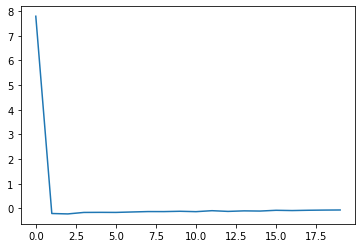

In [133]:
plt.plot(np.arange(0,20),sera[:,4])